In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="3"
of_preds = dict()

In [58]:
import numpy as np
from omnifold import DataLoader, MLP, MultiFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

In [73]:
data_size = 10**4
sim_size = 10**5
mu_true, mu_gen = 0, -1

iterations = 5
dims = 1

rng = np.random.default_rng(1042)
truth = rng.normal(mu_true, 1, (data_size, 1))
gen = rng.normal(mu_gen, 1, (sim_size, 1))

with open("of_preds.pkl", "rb") as f:
    of_preds = pickle.load(f)

deltas_gen = dict()
deltas_of = dict()

Dictionary loaded from of_preds.pkl


In [ ]:
def triangular_discriminator(p, q, bin_widths):
    """
    Triangular discriminator:
      0.5 * sum_i [((p_i - q_i)^2)/(p_i + q_i)] * bin_width_i * 1e3
    Bins where p_i + q_i = 0 contribute zero.
    """
    denom = p + q
    mask = denom > 0
    val = np.zeros_like(p)
    val[mask] = (p[mask] - q[mask])**2 / denom[mask]
    return 0.5 * np.sum(val * bin_widths) * 1e3

In [75]:
smearings = of_preds.keys()
for smearing in smearings:
    print(f"{smearing = }")
    
    data = truth * smearing
    sim = gen * smearing

    truth_train, truth_test, data_train, data_test = train_test_split(
            truth, data, test_size=0.2, random_state=42
    )

    gen_train, gen_test, sim_train, sim_test = train_test_split(
            gen, sim, test_size=0.2, random_state=42
    )

    nature_loader = DataLoader(
		  reco = data_train,
		  normalize=True)
    mc_loader = DataLoader(
		  reco = sim_train,
		  gen = gen_train,
		  normalize=True)
    reco_model = MLP(dims)
    gen_model = MLP(dims)

    omnifold = MultiFold(
        "RAN Comparison",
        reco_model,
        gen_model,
        nature_loader,
        mc_loader,
        batch_size = 512,
        niter = 5,
        epochs = 10,
        verbose = False,
        lr = 5e-5,
    )

    omnifold.Unfold()
    unfolded_weights = omnifold.reweight(gen_test, omnifold.model2, batch_size=1000)
    
    # Instead of skipping, we now append the results if the key already exists.
    if smearing in of_preds:
        of_preds[smearing].append([truth_test, gen_test, unfolded_weights])
    else:
        of_preds[smearing] = [[truth_test, gen_test, unfolded_weights]]

smearing = np.float64(0.0)
INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Normalizing sum of weights to 1000000 ...
INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Normalizing sum of weights to 1000000 ...
171 training steps at reco and 312 steps at gen
ITERATION: 1
RUNNING STEP 1
Last val loss 15.750901222229004
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 8.66225814819336
INFO: Dumping training history ...
ITERATION: 2
RUNNING STEP 1
Last val loss 15.763267517089844
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 8.662893295288086
INFO: Dumping training history ...
ITERATION: 3
RUNNING STEP 1
Last val loss 15.699475288391113
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 8.660296440124512
INFO: Dumping training history ...
ITERATION: 4
RUNNING STEP 1
Last val loss 15.765052795410156
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 8.66394138336181

In [77]:
sorted_keys = sorted([float(k) for k in of_preds.keys()])
print([f"{k:.3f}" for k in sorted_keys])

['0.000', '1.053', '2.105', '3.158', '4.211', '5.000', '5.263', '6.316', '7.368', '8.421', '9.474', '10.000', '10.526', '11.579', '12.632', '13.684', '14.737', '15.000', '15.789', '16.842', '17.895', '18.947', '20.000']


In [78]:
with open("of_preds.pkl", "wb") as f:
    pickle.dump(of_preds, f)

print("Dictionary saved to of_preds.pkl")

Dictionary saved to of_preds.pkl


In [79]:
for smearing in smearings:
    delta_gen_list = []
    delta_of_list = []
    for triplet in of_preds[smearing]:
        truth_test, gen_test, of_weights = triplet

        # Build histograms with density=True
        counts_truth, bin_edges = np.histogram(truth_test, density=True)
        counts_gen,   _         = np.histogram(gen_test, density=True)
        # Use the event-level weights when making the histogram for the reweighted gen.
        counts_of,    _         = np.histogram(gen_test, weights=np.atleast_2d(of_weights).T, density=True)
        
        bin_widths = np.diff(bin_edges)
    
        # Compute the triangular discriminators for this triplet
        delta_gen = triangular_discriminator(counts_gen, counts_truth, bin_widths)
        delta_of  = triangular_discriminator(counts_of,  counts_truth, bin_widths)
        
        # Append the individual delta values
        delta_gen_list.append(delta_gen)
        delta_of_list.append(delta_of)
        
    # Average the deltas over the K triplets for this smearing value
    deltas_gen[smearing] = (np.mean(delta_gen_list), np.std(delta_gen_list)/np.sqrt(len(delta_gen_list) - 1))
    deltas_of[smearing] = (np.mean(delta_of_list), np.std(delta_of_list)/np.sqrt(len(delta_of_list) - 1))

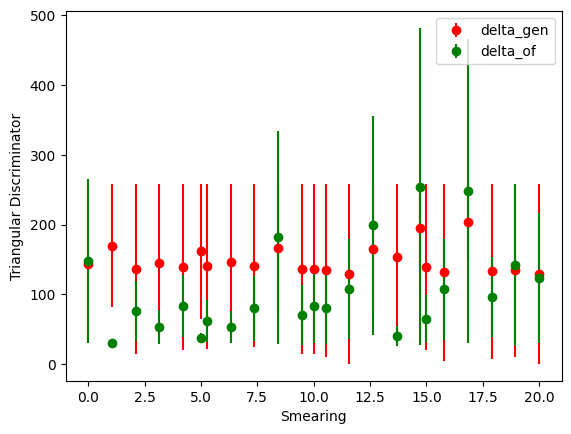

In [85]:
gen_means = [deltas_gen[k][0] for k in sorted_keys]
gen_errs  = [deltas_gen[k][1] for k in sorted_keys]

# Extract means and errors for the OF vs Truth data
of_means  = [deltas_of[k][0] for k in sorted_keys]
of_errs   = [deltas_of[k][1] for k in sorted_keys]

# Plot using error bars
plt.errorbar(smearings, gen_means, yerr=gen_errs, fmt='o', color='r', label='delta_gen')
plt.errorbar(smearings, of_means, yerr=of_errs, fmt='o', color='g', label='delta_of')

# Add labels and legend
plt.xlabel("Smearing")
plt.ylabel("Triangular Discriminator")
plt.legend()
plt.show()

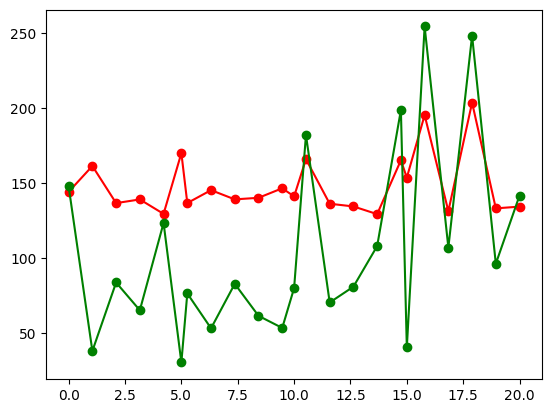

In [86]:
plt.plot(sorted_keys, gen_means, marker='o', color='r', label='delta_gen')
plt.plot(sorted_keys, of_means, marker='o', color='g', label='delta_of')